<a href="https://colab.research.google.com/github/tskmr/Reliability/blob/main/F_depend_sigma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
library(tidyverse)

### データの生成

In [145]:
n = 200
mu = 10
sigma = .3
set.seed(1)
t0 = rweibull(n, shape=1/sigma, scale=exp(mu))
censoring = rbinom(n, 1, 0.3)
t = t0
for(i in 1:n){
  if(censoring[i]==0){
    t[i] = runif(1, 0, t[i])
  }
}
d = data.frame(t0, censoring, t)
d %>% head


,t0,censoring,t
,<dbl>,<int>,<dbl>
1,23972.78,0,15795.130
2,21950.36,0,4062.352
3,18481.22,0,17638.076
4,10914.62,0,9799.672
5,25366.90,0,23938.668
6,11270.52,0,8156.374


### 最尤推定


log location scale family (llsf) の尤度の定義


In [146]:
li_for_llsf_ver1 = function(t, par, delta_i){
  mu = par[1]
  sigma = par[2]
  pdf = 1/(sigma*t) * phi((log(t)-mu)/sigma)
  cdf = Phi((log(t)-mu)/sigma)
  delta_i * log(pdf) + (1-delta_i) * log(1-cdf)
}
li_for_llsf_ver2 = function(t, par, delta_i){
  mu = par[1]
  sigma = par[2]
  delta_i * log.pdf(t, 1/sigma, exp(mu)) + (1-delta_i) * log(1-cdf(t, 1/sigma, exp(mu)))
}
loglikelihood = function(t, delta){# 対数尤度
  function(par){
    sum(li_for_llsf_ver2(t, par, delta))
  }
}

分布を指定


In [147]:
psev = function(z){ 1-exp(-exp(z)) }
dsev = function(z){ exp(z-exp(z)) }
qsev = function(p){ log(-log(1-p)) }
Phi = psev # ワイブル分布
phi = dsev

log.cdf = function(t, m, eta) pweibull(t, shape=m, scale= eta, log.p=TRUE)
log.sf = function(t, m, eta) pweibull(t, shape=m, scale= eta, log.p=TRUE, lower.tail = TRUE)
log.pdf = function(t, m, eta) dweibull(t, shape=m, scale= eta, log=TRUE)
cdf = function(t, m, eta) exp(log.cdf(t, m, eta))
sf = function(t, m, eta) exp(log.sf(t, m, eta))
pdf = function(t, m, eta) exp(log.pdf(t, m, eta))

l = loglikelihood(d$t, d$censoring)
l(c(mu, sigma))

[1] -540.8477

最尤推定値を求める

In [148]:
initial_par = c(mu, sigma)
res = optim(initial_par, l, control = list(fnscale=-1), hessian = TRUE)
res

hat.mu = res$par[1]; hat.mu; exp(hat.mu)
hat.sigma = res$par[2]; hat.sigma; 1/hat.sigma

H_n = res$hessian; H_n
fisher.information = -H_n; fisher.information/n
aVar = solve(fisher.information); aVar
sqrt(aVar)

c(hat.mu-qnorm(0.975) * sqrt(aVar[1,1]),
  hat.mu+qnorm(0.975) * sqrt(aVar[1,1]))
c(hat.sigma-qnorm(0.975) * sqrt(aVar[2,2]),
  hat.sigma+qnorm(0.975) * sqrt(aVar[2,2]))


Warning message in dweibull(t, shape = m, scale = eta, log = TRUE):
“NaNs produced”
Warning message in pweibull(t, shape = m, scale = eta, log.p = TRUE):
“NaNs produced”
Warning message in dweibull(t, shape = m, scale = eta, log = TRUE):
“NaNs produced”
Warning message in pweibull(t, shape = m, scale = eta, log.p = TRUE):
“NaNs produced”


-1453.2988,309.6895
309.6895,-2946.2432


[1] 10.05259

[1] 23215.74

[1] 0.1873519

[1] 5.337549

-1453.2988,309.6895
309.6895,-2946.2432


7.266494,-1.548447
-1.548447,14.731216


0.0007038554,0.0000739846
0.0000739846,0.0003471921


0.02653027,0.00860143
0.00860143,0.01863309


[1] 10.00059 10.10458

[1] 0.1508317 0.2238721

### 予測分布

In [149]:
hat.F = function(t) { Phi((log(t)-hat.mu)/hat.sigma) }
var.F = function(t){
  jF_mu = -1/(hat.sigma) * phi((log(t)-hat.mu)/hat.sigma)
  jF_sigma = -(log(t)-hat.mu)/hat.sigma^2 * phi((log(t)-hat.mu)/hat.sigma)
  jF = matrix(c(jF_mu, jF_sigma), ncol=2)
  jF%*%aVar%*%t(jF)
}

In [150]:
hat.F = function(t) { cdf(t, 1/hat.sigma, exp(hat.mu)) }
var.F = function(t){
  jF_mu = -t * pdf(t, 1/hat.sigma, exp(hat.mu))
  jF_sigma = -(log(t)-hat.mu)/hat.sigma * t * pdf(t, 1/hat.sigma, exp(hat.mu))
  jF = matrix(c(jF_mu, jF_sigma), ncol=2)
  jF%*%aVar%*%t(jF)
}

In [151]:
# log.max.t = log(-log(1-0.99999999))*hat.sigma + hat.mu
log.max.t = log(80000)
log.t = seq(log(1000), log.max.t, len=200)
t = exp(log.t)

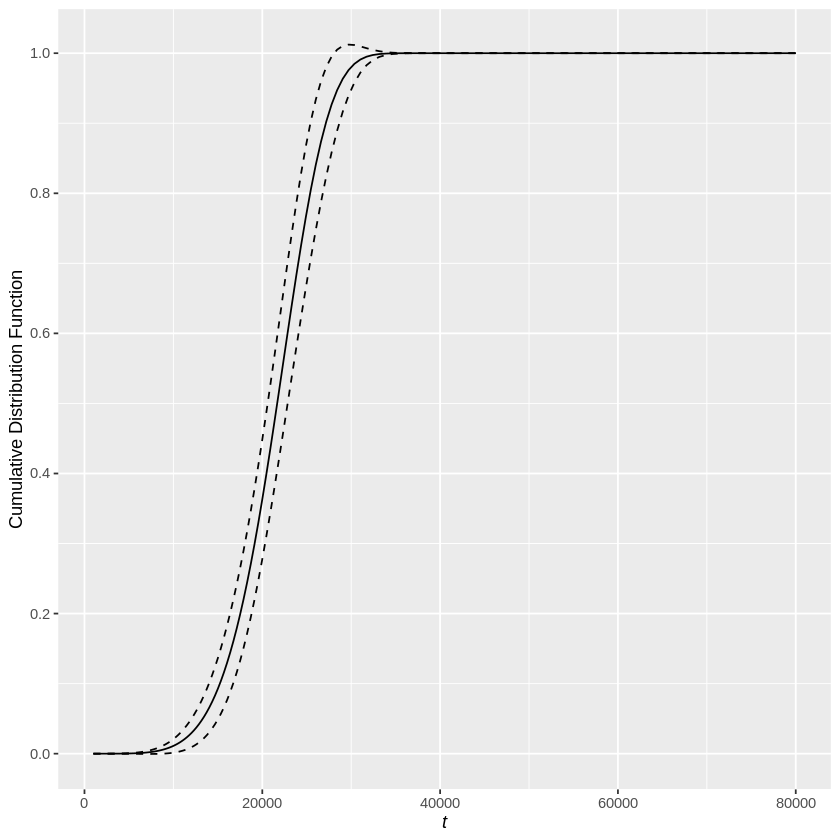

In [152]:
dFT =
  data.frame(t,
             mean=hat.F(t),
             se = sapply(t, function(t) sqrt(var.F(t))),
             upper=sapply(t, function(t) hat.F(t)+qnorm(0.975)*sqrt(var.F(t))),
             lower=sapply(t, function(t) hat.F(t)-qnorm(0.975)*sqrt(var.F(t))))
# dFT = dFT %>% mutate(upper = ifelse(upper>1, 1, upper))
p1 = dFT %>%
  ggplot()+geom_line(aes(t, mean))+
  geom_line(aes(t, upper), linetype=2)+
  geom_line(aes(t, lower), linetype=2)+
  xlab(bquote(italic(t)))+ylab("Cumulative Distribution Function")+
  scale_y_continuous(breaks = seq(0, 1, by=.2))
p1


In [153]:
# FT = hat.F(t)
log.FT = pweibull(t, shape=1/hat.sigma, scale= exp(hat.mu), log.p=TRUE)
log.1mFT = pweibull(t, shape=1/hat.sigma, scale= exp(hat.mu), log.p=TRUE, lower.tail = FALSE)
F1mF = exp(log.FT + log.1mFT)
FT = exp(log.FT)
mFT = exp(log.1mFT)
sdFT = sapply(t, function(t)sqrt(var.F(t)))
w = exp(qnorm(0.975) * sdFT/F1mF)
lower.FT = FT/(FT+mFT*w)
upper.FT = FT/(FT+mFT/w)
dFTw = data.frame(t=t, FT=FT, mFT=mFT, F1mF, sdFT, w, lower.FT, upper.FT)
dFTw %>% tail


,t,FT,mFT,F1mF,sdFT,w,lower.FT,upper.FT
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
195,71659.48,1,9.559633e-179,9.559633e-179,0,1,1,1
196,73254.94,1,5.995818e-201,5.995818e-201,0,1,1,1
197,74885.92,1,6.399545e-226,6.399545e-226,0,1,1,1
198,76553.22,1,5.247836e-254,5.247836e-254,0,1,1,1
199,78257.64,1,1.351779e-285,1.351779e-285,0,1,1,1
200,80000.00,1,4.001932e-321,4.001932e-321,0,1,1,1


Warning message:
“Transformation introduced infinite values in continuous y-axis”


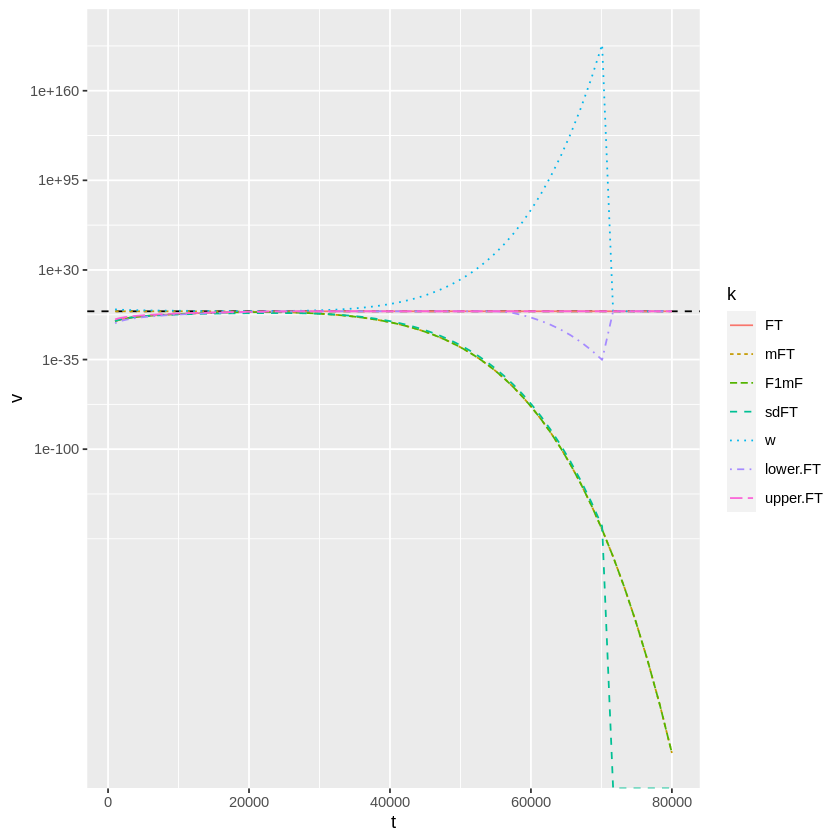

In [154]:
cn = colnames(dFTw)[-1]
dFTw %>%
  pivot_longer(!t, names_to="k", values_to="v") %>%
  mutate(k=factor(k, levels=cn)) %>%
  ggplot()+
  geom_hline(yintercept=1, linetype=2)+
  geom_line(aes(t, v, col=k, linetype=k))+
  # scale_x_log10() +
  scale_y_log10()


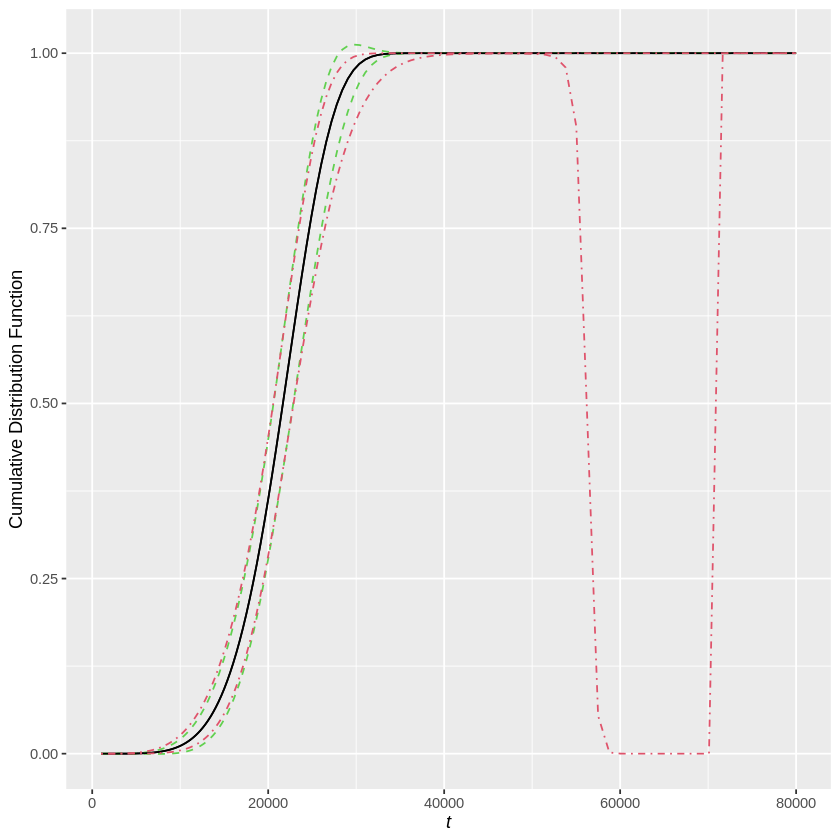

In [155]:
ggplot()+
  geom_line(data=dFT, aes(t, mean), col=1)+
  geom_line(data=dFT, aes(t, upper), col=3, linetype=2)+
  geom_line(data=dFT, aes(t, lower), col=3, linetype=2)+
  geom_line(data=dFTw, aes(t, FT), col=1)+
  geom_line(data=dFTw, aes(t, lower.FT), col=2, linetype=4)+
  geom_line(data=dFTw, aes(t, upper.FT), col=2, linetype=4)+
  xlab(bquote(italic(t)))+ylab("Cumulative Distribution Function")
